In [2]:
from datasets import load_dataset, Audio
import os
import librosa.display
import evaluate
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

/home/unkno/stat project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-04 17:56:51.146196: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 17:56:51.370456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-04 17:56:51.455453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-04 17:56:51

In [4]:
SNORING_DATA_PATH = os.path.join('./data','1')
NOT_SNORING_DATA_PATH = os.path.join('./data','0')
SNORING_FILE = os.path.join(SNORING_DATA_PATH,'1_0.wav')
NOT_SNORING_FILE = os.path.join(NOT_SNORING_DATA_PATH,'0_0.wav')

In [5]:
os.listdir('./data')

['Test_long_MP3_data', '1', 'Snoring_dataset.txt', '0']

In [6]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [7]:
if os.path.exists('Spectrograms/Sn/1_0.png'):
    print("Spectrograms already exsit. Skipping img creation")
else:
    create_pngs_from_wavs(SNORING_DATA_PATH, 'Spectrograms/Sn')

Spectrograms already exsit. Skipping img creation


In [8]:
if os.path.exists('Spectrograms/notSn/0_0.png'):
    print("Spectrograms already exsit. Skipping img creation")
else:
    create_pngs_from_wavs(NOT_SNORING_DATA_PATH, 'Spectrograms/notSn')

Spectrograms already exsit. Skipping img creation


In [9]:
from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []

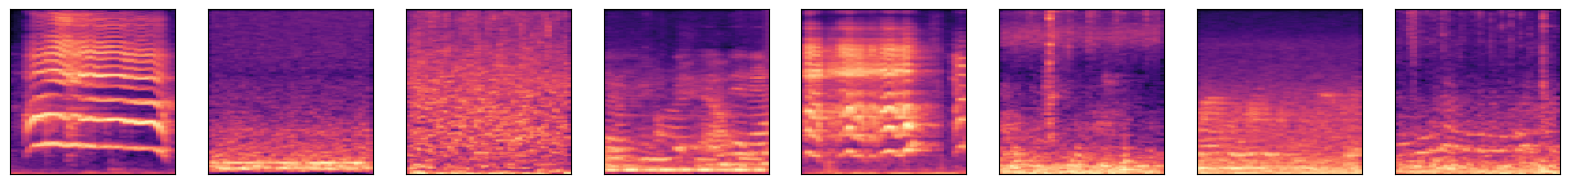

In [10]:
images, labels = load_images_from_path('Spectrograms/notSn', 0)
show_images(images)
    
x += images
y += labels

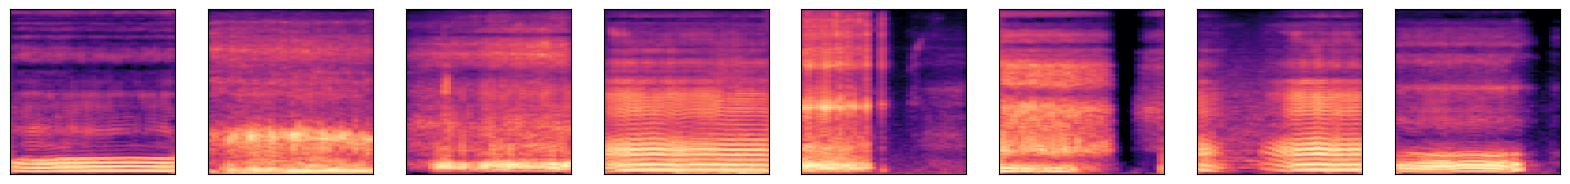

In [11]:
images, labels = load_images_from_path('Spectrograms/Sn', 1)
show_images(images)
    
x += images
y += labels

In [12]:

x_train, x_temp, y_train, y_temp = train_test_split(x, y, stratify=y, test_size=0.4, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255
x_val_norm = np.array(x_val) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_val_encoded = to_categorical(y_val)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/unkno/stat project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-30 22:28:00.844006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-30 22:28:00.964049: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-30 22:28:00.964090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,210,498 (73.28 MB)

 Trainable params: 19,210,498 (73.28 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=32, epochs=20)

Epoch 1/20


I0000 00:00:1746026883.680382   24014 service.cc:145] XLA service 0x7f833c0168c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746026883.682237   24014 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-04-30 22:28:03.715569: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-30 22:28:03.858435: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1746026884.485587   24094 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_437', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1746026884.510244   24091 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_437', 368 bytes spill stores, 368 bytes spill loads

2025-04-30

 1/19 ━━━━━━━━━━━━━━━━━━━━ 7:13 24s/step - accuracy: 0.4688 - loss: 0.7016

I0000 00:00:1746026906.878636   24014 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4700 - loss: 1.3271

I0000 00:00:1746026909.599362   24227 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_437', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1746026909.646500   24229 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_437', 432 bytes spill stores, 356 bytes spill loads

2025-04-30 22:28:43.587698: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,32,111,111]{3,2,1,0}, f32[24,128,109,109]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-04-30 22:28:43.861120: E external/local_xla/xla/service/slow

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4717 - loss: 1.3068   

I0000 00:00:1746026931.456346   24418 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_124', 128 bytes spill stores, 128 bytes spill loads



19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4732 - loss: 1.2884 - val_accuracy: 0.5750 - val_loss: 0.6636
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.5852 - loss: 0.6606 - val_accuracy: 0.8700 - val_loss: 0.4502
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.7852 - loss: 0.4823 - val_accuracy: 0.8850 - val_loss: 0.2804
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.8832 - loss: 0.3333 - val_accuracy: 0.9250 - val_loss: 0.1844
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9107 - loss: 0.2557 - val_accuracy: 0.9600 - val_loss: 0.1425
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9565 - loss: 0.1250 - val_accuracy: 0.9350 - val_loss: 0.1373
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9771 - loss: 0.0703 - val_accuracy: 0.9700 - val_loss: 0.0832
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9772 - loss: 0.0975 - val_accuracy: 0.9550 - val_lo

[]

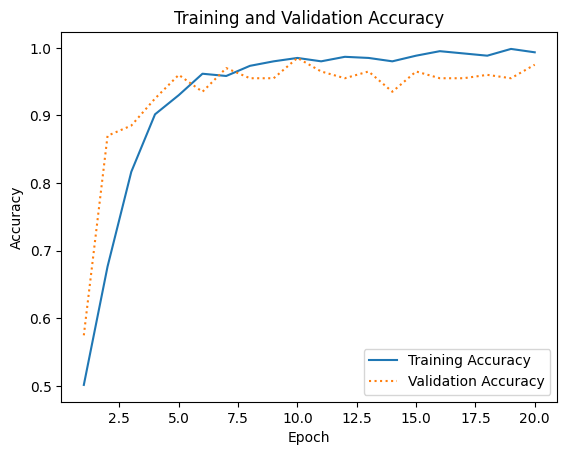

In [13]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


Text(109.44999999999997, 0.5, 'Actual label')

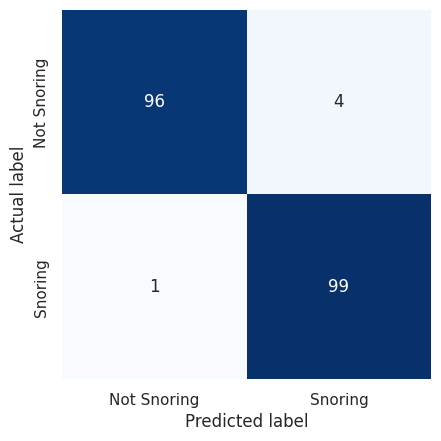

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()


y_predicted = model.predict(x_test_norm)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['Not Snoring', 'Snoring']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Text(109.44999999999997, 0.5, 'Actual label')

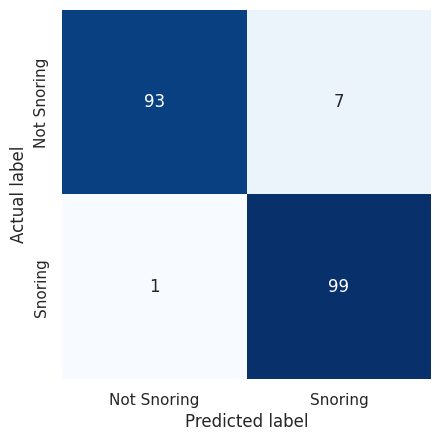

In [15]:
y_predicted = model.predict(x_val_norm)
mat = confusion_matrix(y_val_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['Not Snoring', 'Snoring']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [16]:
if not os.path.exists('./saved_models'):
    os.makedirs('./saved_models')

model.save('./saved_models/snoring_detection_model.h5')

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_train_norm = preprocess_input(np.array(x_train))
x_test_norm = preprocess_input(np.array(x_test))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)
val_features = base_model.predict(x_val_norm)

I0000 00:00:1746356318.919599    2255 service.cc:145] XLA service 0x7ff5b000d3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746356318.919643    2255 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-05-04 17:58:38.945040: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-04 17:58:39.164870: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

I0000 00:00:1746356322.802379    2255 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [18]:
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/unkno/stat project/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
hist = model.fit(train_features, y_train_encoded, validation_data=(test_features, y_test_encoded), batch_size=32, epochs=20)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6178 - loss: 45.3510 - val_accuracy: 0.9400 - val_loss: 2.7037
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9606 - loss: 0.7774 - val_accuracy: 0.9500 - val_loss: 1.2219
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9888 - loss: 0.1256 - val_accuracy: 0.9600 - val_loss: 0.9138
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9983 - loss: 0.0053 - val_accuracy: 0.9650 - val_loss: 0.6699
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9976 - loss: 0.0060 - val_accuracy: 0.9500 - val_loss: 0.6889
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 1.0000 - loss: 3.1627e-07 - val_accuracy: 0.9550 - val_loss: 0.6680
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 1.1011e-06 - val_accuracy: 0.9600 - val_loss: 0.6642
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 2.2569e-06 - val_accurac

[]

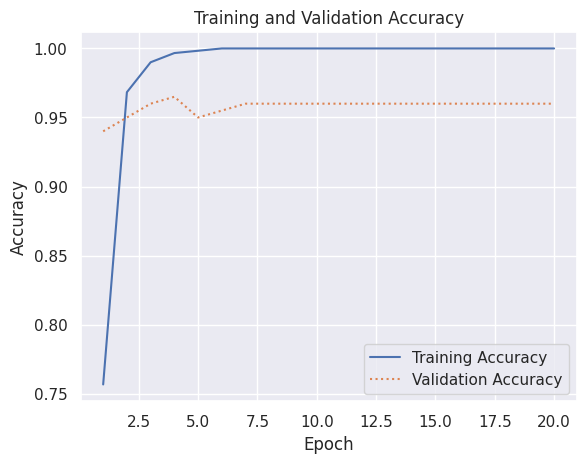

In [20]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Text(109.44999999999997, 0.5, 'Actual label')

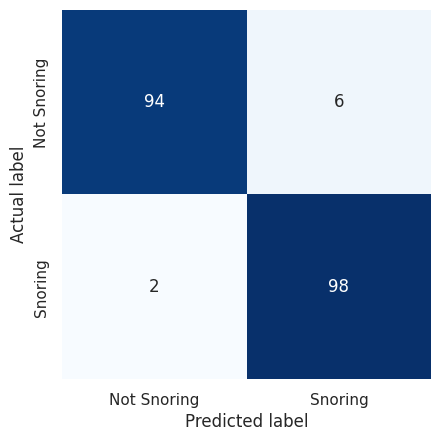

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = model.predict(test_features)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['Not Snoring', 'Snoring']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Text(109.44999999999997, 0.5, 'Actual label')

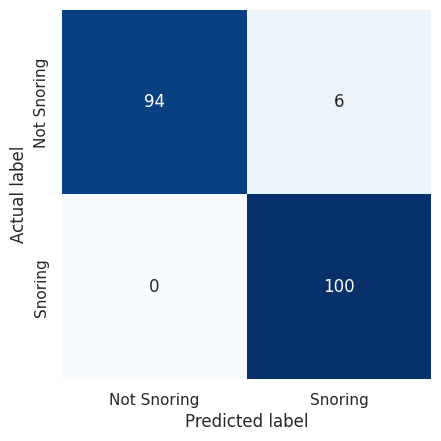

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = model.predict(val_features)
mat = confusion_matrix(y_val_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['Not Snoring', 'Snoring']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [23]:
if not os.path.exists('./saved_models'):
    os.makedirs('./saved_models')

model.save('./saved_models/snoring_detection_MobileNet.h5')

In [25]:
def test_single_image(image_path):
    test_image = image.load_img(image_path, target_size=(224, 224, 3))
    test_image_array = image.img_to_array(test_image)
    # Save the normalized version for display
    display_image = test_image_array / 255.0
    
    # Preprocess for model prediction
    test_image_preprocessed = preprocess_input(np.expand_dims(test_image_array, axis=0))

    # Get features using the base model
    test_features = base_model.predict(test_image_preprocessed)
    
    # Make prediction using our trained model
    prediction = model.predict(test_features)
    
    plt.imshow(image.img_to_array(test_image) / 255)  # normalize the image
    plt.axis('off')
    plt.title(f'Prediction: {"Snoring" if prediction[0][1] > 0.5 else "Not Snoring"}\nConfidence: {max(prediction[0][0], prediction[0][1]):.2%}')
    plt.show()



In [18]:
loaded_model = tf.keras.models.load_model('./saved_models/snoring_detection_model.h5')

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


Text(109.44999999999997, 0.5, 'Actual label')

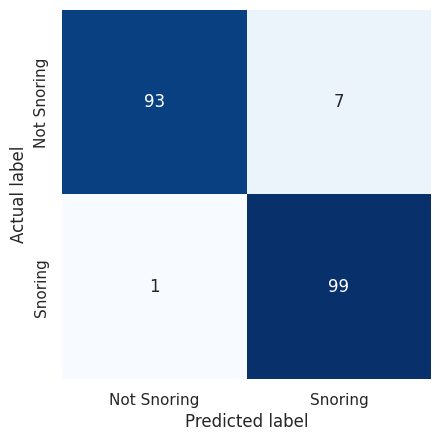

In [19]:
y_predicted = loaded_model.predict(x_val_norm)
mat = confusion_matrix(y_val_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['Not Snoring', 'Snoring']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [20]:
mobilenet_model = tf.keras.models.load_model('./saved_models/snoring_detection_MobileNet.h5')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Text(109.44999999999997, 0.5, 'Actual label')

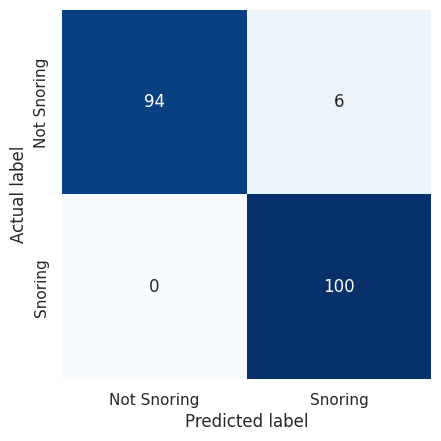

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = mobilenet_model.predict(val_features)
mat = confusion_matrix(y_val_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['Not Snoring', 'Snoring']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')